In [5]:
#!pip install -U layoutparser

In [6]:
#!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

In [7]:
#!pip install layoutparser[ocr]

In [ ]:
#!git clone https://github.com/Layout-Parser/layout-parser.git

In [8]:
#%cd layout-parser/

In [37]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/Oversampling_Techniques_for_Bankruptcy_Prediction__page-0010.jpg")
image = image[..., ::-1]

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


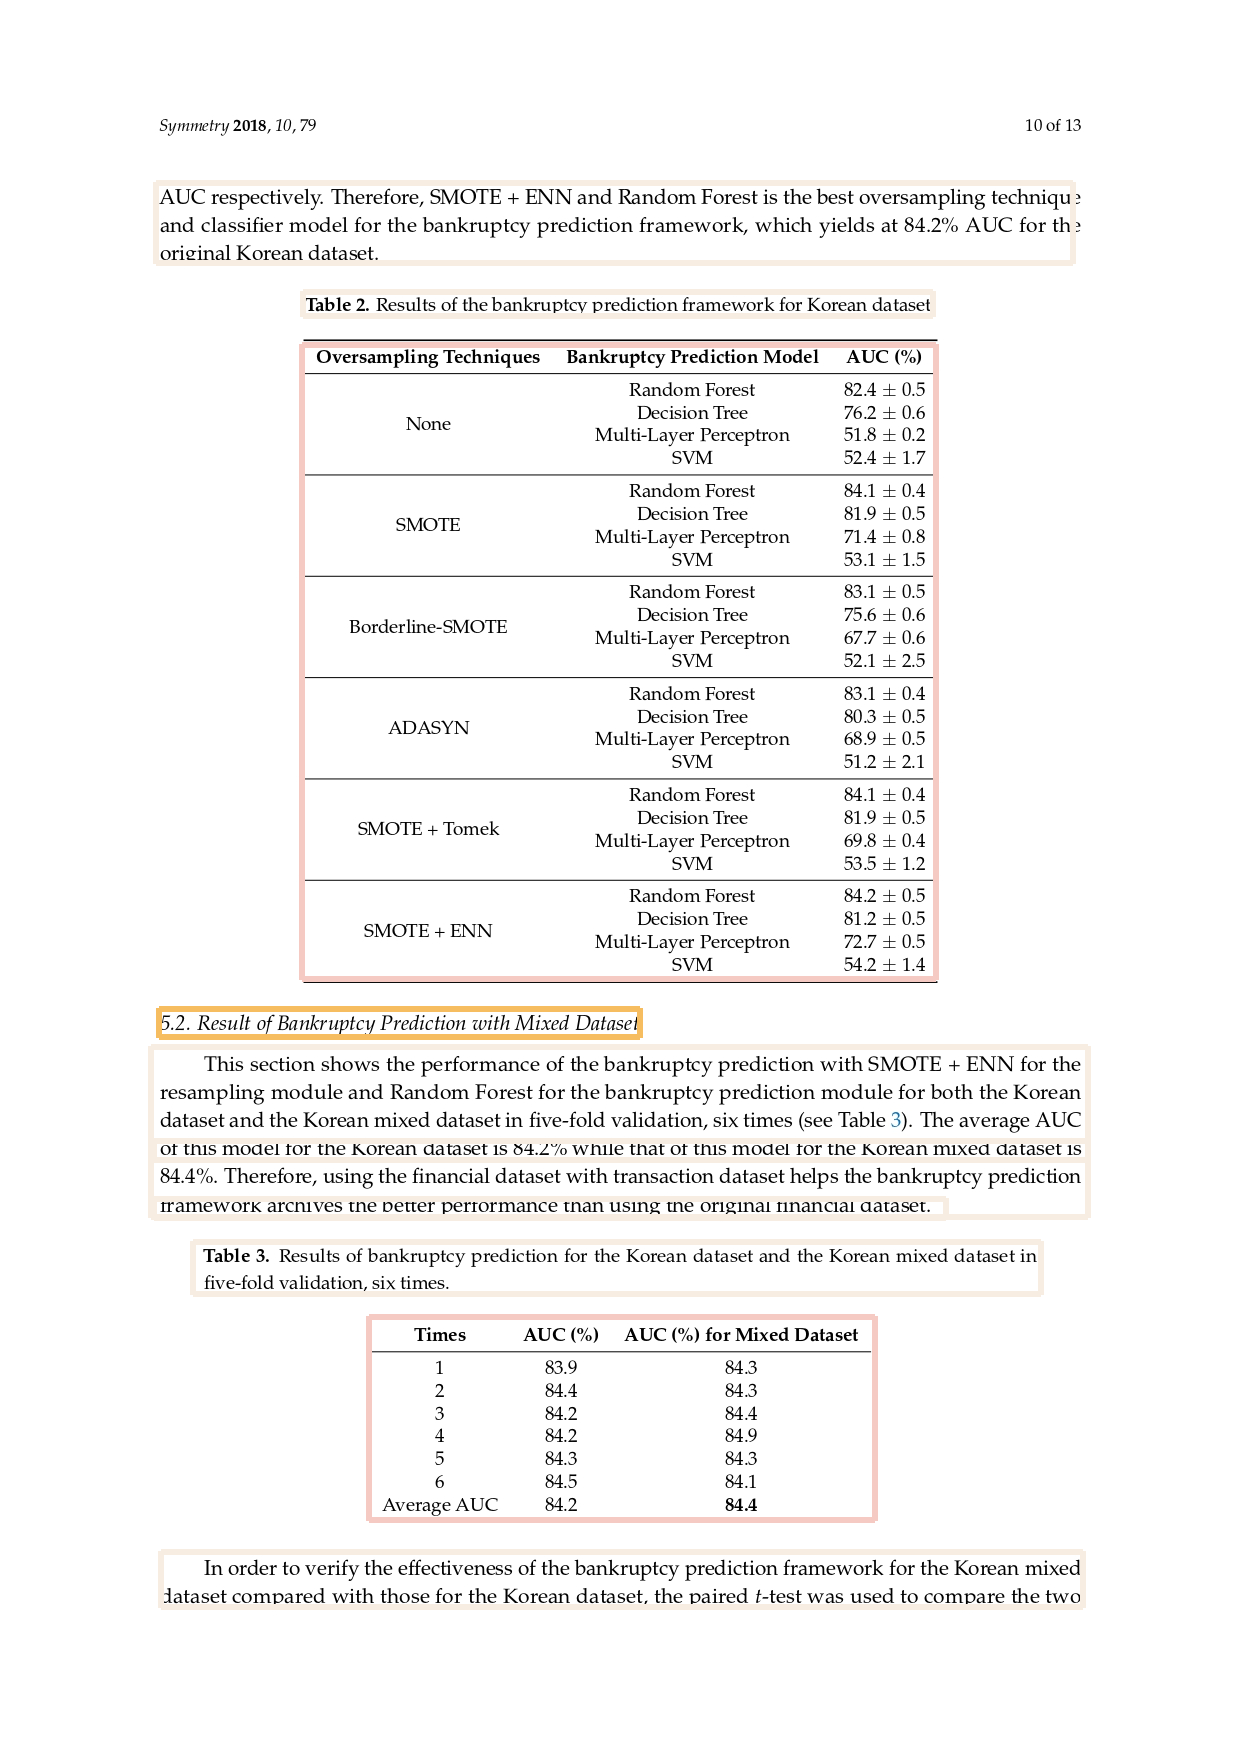

In [38]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image)
lp.draw_box(image, layout,)

In [60]:
text_blocks = lp.Layout([b for b in layout if b.type=="Text"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=303.5220947265625, y_1=291.32135009765625, x_2=932.1381225585938, y_2=316.022216796875), text=None, id=None, type=Text, parent=None, next=None, score=0.9944429993629456), TextBlock(block=Rectangle(x_1=193.1989288330078, y_1=1241.2637939453125, x_2=1040.0025634765625, y_2=1294.229736328125), text=None, id=None, type=Text, parent=None, next=None, score=0.9602376222610474), TextBlock(block=Rectangle(x_1=151.92095947265625, y_1=1046.1842041015625, x_2=1087.213623046875, y_2=1217.8614501953125), text=None, id=None, type=Text, parent=None, next=None, score=0.8536456823348999), TextBlock(block=Rectangle(x_1=161.1805419921875, y_1=1551.9627685546875, x_2=1082.0250244140625, y_2=1607.355712890625), text=None, id=None, type=Text, parent=None, next=None, score=0.8493146896362305), TextBlock(block=Rectangle(x_1=156.63368225097656, y_1=182.2372589111328, x_2=1072.379150390625, y_2=263.7188720703125), text=None, id=None, type=Text, parent=None, next=None

In [61]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [62]:
figure_blocks

Layout(_blocks=[], page_data={})

In [63]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [64]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

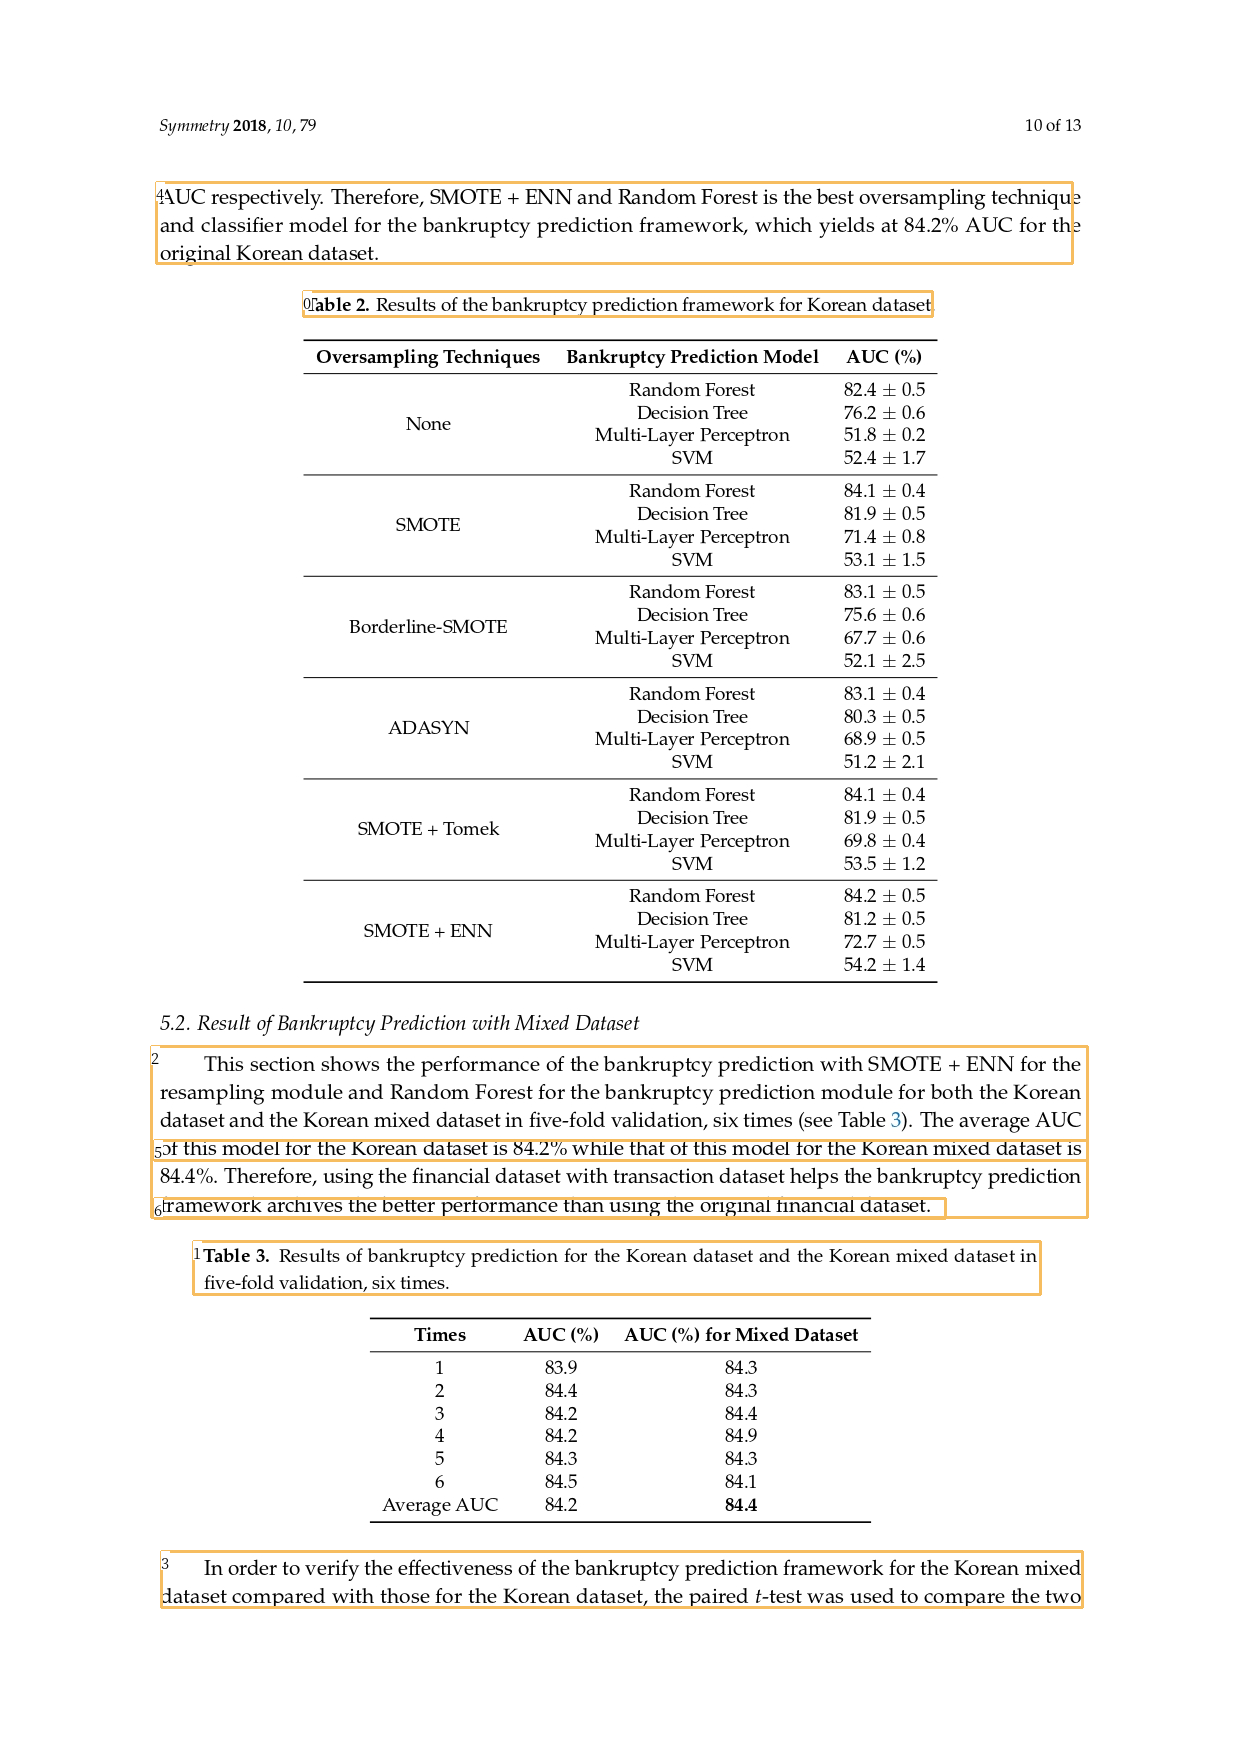

In [65]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [66]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [18]:
#!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (12.5 MB

In [67]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [68]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Table 2. Results of the bankruptcy prediction framework for Korean dataset.

---
Table 3. Results of bankruptcy prediction for the Korean dataset and the Korean mixed dataset in
five-fold validation, six times.

---
This section shows the performance of the bankruptcy prediction with SMOTE + ENN for the
resampling module and Random Forest for the bankruptcy prediction module for both the Korean
dataset and the Korean mixed dataset in five-fold validation, six times (see Table 3). The average AUC
of this model for the Korean dataset is 84.2% while that of this model for the Korean mixed dataset is
84.4%. Therefore, using the financial dataset with transaction dataset helps the bankruptcy prediction
framework archives the better performance than using the original financial dataset.

---
In order to verify the effectiveness of the bankruptcy prediction framework for the Korean mixed
dataset compared with those for the Korean dataset, the paired t-test was used to compare the two

---

In [69]:
text_blocks.get_texts()

['Table 2. Results of the bankruptcy prediction framework for Korean dataset.\n\x0c',
 'Table 3. Results of bankruptcy prediction for the Korean dataset and the Korean mixed dataset in\nfive-fold validation, six times.\n\x0c',
 'This section shows the performance of the bankruptcy prediction with SMOTE + ENN for the\nresampling module and Random Forest for the bankruptcy prediction module for both the Korean\ndataset and the Korean mixed dataset in five-fold validation, six times (see Table 3). The average AUC\nof this model for the Korean dataset is 84.2% while that of this model for the Korean mixed dataset is\n84.4%. Therefore, using the financial dataset with transaction dataset helps the bankruptcy prediction\nframework archives the better performance than using the original financial dataset.\n\x0c',
 'In order to verify the effectiveness of the bankruptcy prediction framework for the Korean mixed\ndataset compared with those for the Korean dataset, the paired t-test was used to 

In [70]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=303.5220947265625, y_1=291.32135009765625, x_2=932.1381225585938, y_2=316.022216796875), text=Table 2. Results of the bankruptcy prediction framework for Korean dataset.
, id=0, type=Text, parent=None, next=None, score=0.9944429993629456)
TextBlock(block=Rectangle(x_1=193.1989288330078, y_1=1241.2637939453125, x_2=1040.0025634765625, y_2=1294.229736328125), text=Table 3. Results of bankruptcy prediction for the Korean dataset and the Korean mixed dataset in
five-fold validation, six times.
, id=1, type=Text, parent=None, next=None, score=0.9602376222610474)
TextBlock(block=Rectangle(x_1=151.92095947265625, y_1=1046.1842041015625, x_2=1087.213623046875, y_2=1217.8614501953125), text=This section shows the performance of the bankruptcy prediction with SMOTE + ENN for the
resampling module and Random Forest for the bankruptcy prediction module for both the Korean
dataset and the Korean mixed dataset in five-fold validation, six times (see Table 3). The aver

In [32]:
'''!pip install spacy
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
!pip install click==7.1.1'''

     |████████████████████████████████| 51 kB 97 kB/s 
     |████████████████████████████████| 1.1 MB 9.4 MB/s 
     |████████████████████████████████| 6.2 MB 33.7 MB/s 
     |████████████████████████████████| 3.8 MB 34.6 MB/s 
     |████████████████████████████████| 457 kB 45.0 MB/s 
     |████████████████████████████████| 653 kB 49.8 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 181 kB 38.6 MB/s 
     |████████████████████████████████| 10.1 MB 43.8 MB/s 
     |████████████████████████████████| 58 kB 3.3 MB/s 
     |████████████████████████████████| 6.6 MB 38.7 MB/s 
     |████████████████████████████████| 880 kB 39.6 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e9e05781ba05ecf01a139ac98712355b27248bbb71e069129e40e291bb0b3313
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40

     |████████████████████████████████| 460.3 MB 19 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
     |████████████████████████████████| 82 kB 864 kB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2


In [72]:
import spacy
nlp = spacy.load("en_core_web_trf")

In [75]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [76]:
sentence

['Table 2. Results of the bankruptcy prediction framework for Korean dataset.\n\x0c',
 'Table 3. Results of bankruptcy prediction for the Korean dataset and the Korean mixed dataset in\nfive-fold validation, six times.\n\x0c',
 'This section shows the performance of the bankruptcy prediction with SMOTE + ENN for the\nresampling module and Random Forest for the bankruptcy prediction module for both the Korean\ndataset and the Korean mixed dataset in five-fold validation, six times (see Table 3). The average AUC\nof this model for the Korean dataset is 84.2% while that of this model for the Korean mixed dataset is\n84.4%. Therefore, using the financial dataset with transaction dataset helps the bankruptcy prediction\nframework archives the better performance than using the original financial dataset.\n\x0c',
 'In order to verify the effectiveness of the bankruptcy prediction framework for the Korean mixed\ndataset compared with those for the Korean dataset, the paired t-test was used to 

In [77]:
".".join(sentence)

'Table 2. Results of the bankruptcy prediction framework for Korean dataset.\n\x0c.Table 3. Results of bankruptcy prediction for the Korean dataset and the Korean mixed dataset in\nfive-fold validation, six times.\n\x0c.This section shows the performance of the bankruptcy prediction with SMOTE + ENN for the\nresampling module and Random Forest for the bankruptcy prediction module for both the Korean\ndataset and the Korean mixed dataset in five-fold validation, six times (see Table 3). The average AUC\nof this model for the Korean dataset is 84.2% while that of this model for the Korean mixed dataset is\n84.4%. Therefore, using the financial dataset with transaction dataset helps the bankruptcy prediction\nframework archives the better performance than using the original financial dataset.\n\x0c.In order to verify the effectiveness of the bankruptcy prediction framework for the Korean mixed\ndataset compared with those for the Korean dataset, the paired t-test was used to compare the t

In [78]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


2 CARDINAL
Korean NORP
3 CARDINAL
Korean NORP
Korean NORP
five CARDINAL
six CARDINAL
Korean NORP
Korean NORP
five CARDINAL
six CARDINAL
3 CARDINAL
Korean NORP
84.2% PERCENT
Korean NORP
84.4% PERCENT
Korean NORP
Korean NORP
two CARDINAL
84.2% PERCENT
Korean NORP
Korean NORP
84.2% PERCENT
Korean NORP


In [111]:
import cv2
image2 = cv2.imread("/content/layout-parser/examples/data/sample-invoice.jpg")
image2 = image2[..., ::-1]

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


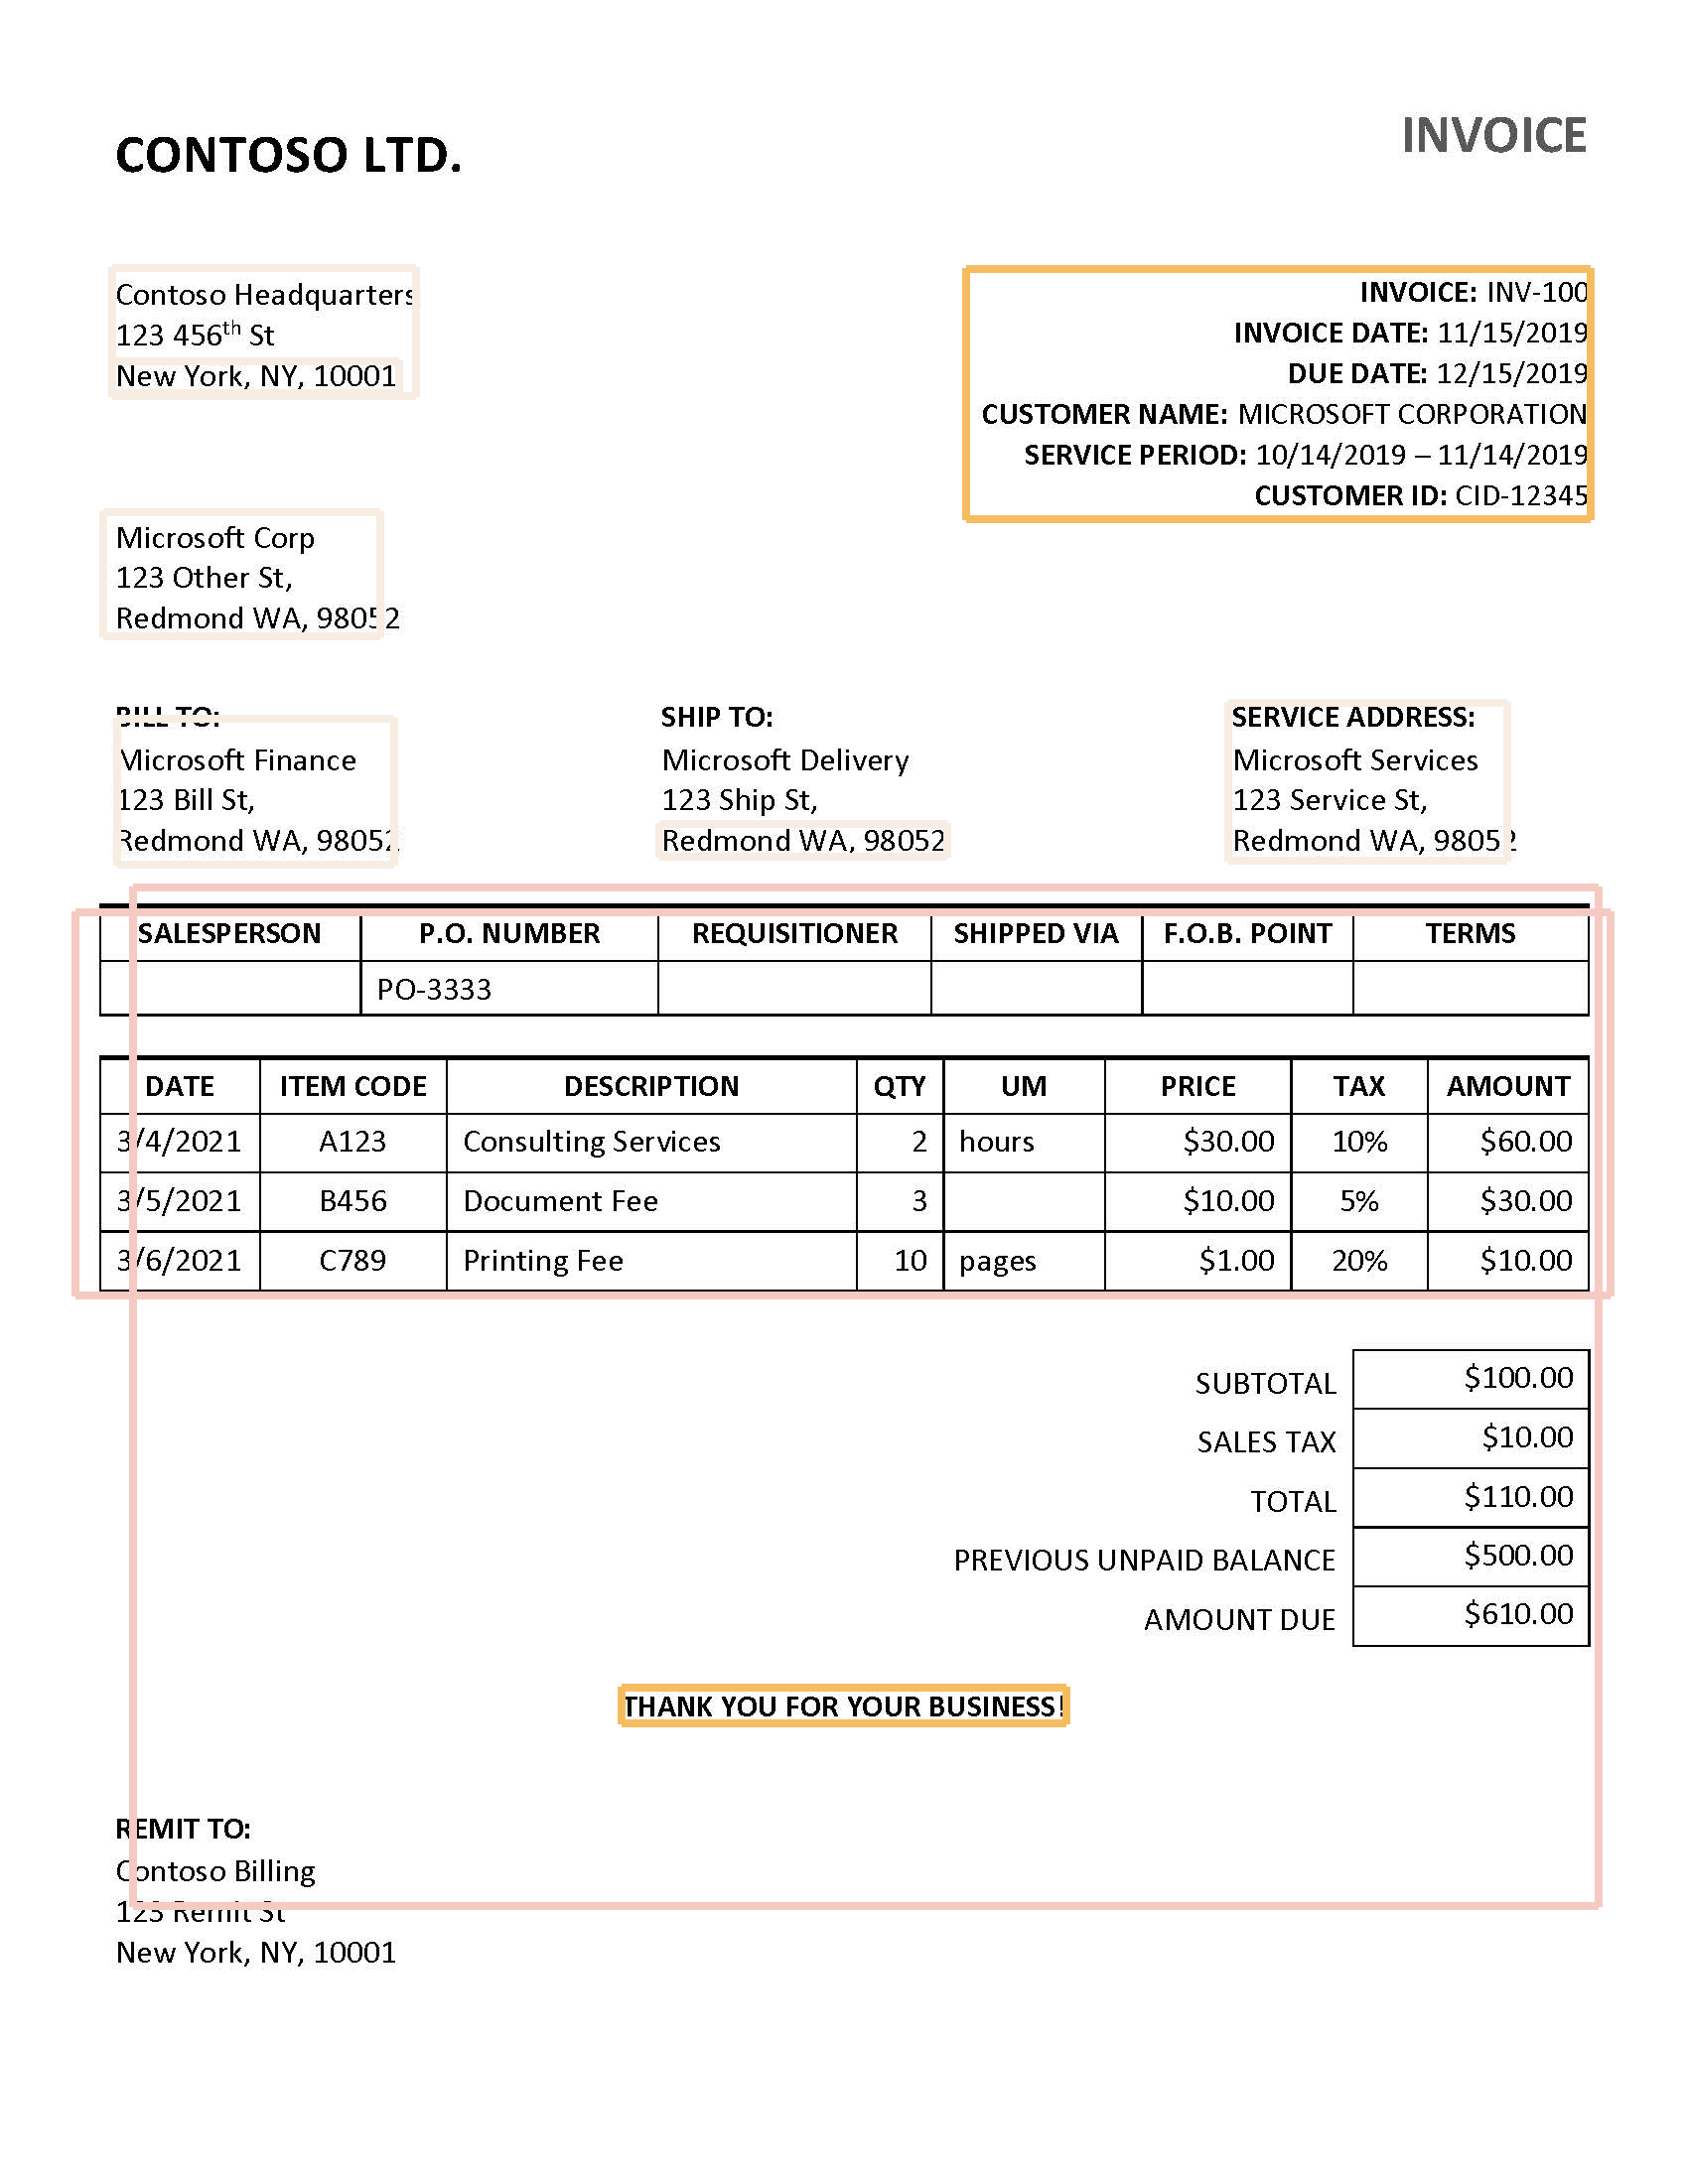

In [112]:
model2 = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout2 = model2.detect(image2)
lp.draw_box(image2, layout2,)

In [113]:
text_blocks2 = lp.Layout([a for a in layout2 if a.type=="Table"])
text_blocks2

Layout(_blocks=[TextBlock(block=Rectangle(x_1=76.35953521728516, y_1=918.3372192382812, x_2=1621.434326171875, y_2=1305.1419677734375), text=None, id=None, type=Table, parent=None, next=None, score=0.7971948385238647), TextBlock(block=Rectangle(x_1=134.96868896484375, y_1=893.4752197265625, x_2=1609.5634765625, y_2=1920.9112548828125), text=None, id=None, type=Table, parent=None, next=None, score=0.7595821619033813)], page_data={})

In [114]:
figure_blocks2 = lp.Layout([a for a in layout2 if a.type=='Figure'])
figure_blocks2

Layout(_blocks=[], page_data={})

In [115]:
text_blocks2 = lp.Layout([b for b in text_blocks2 \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks2)])

In [116]:
h, w = image2.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image2)

left_blocks = text_blocks2.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks2 if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks2 = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

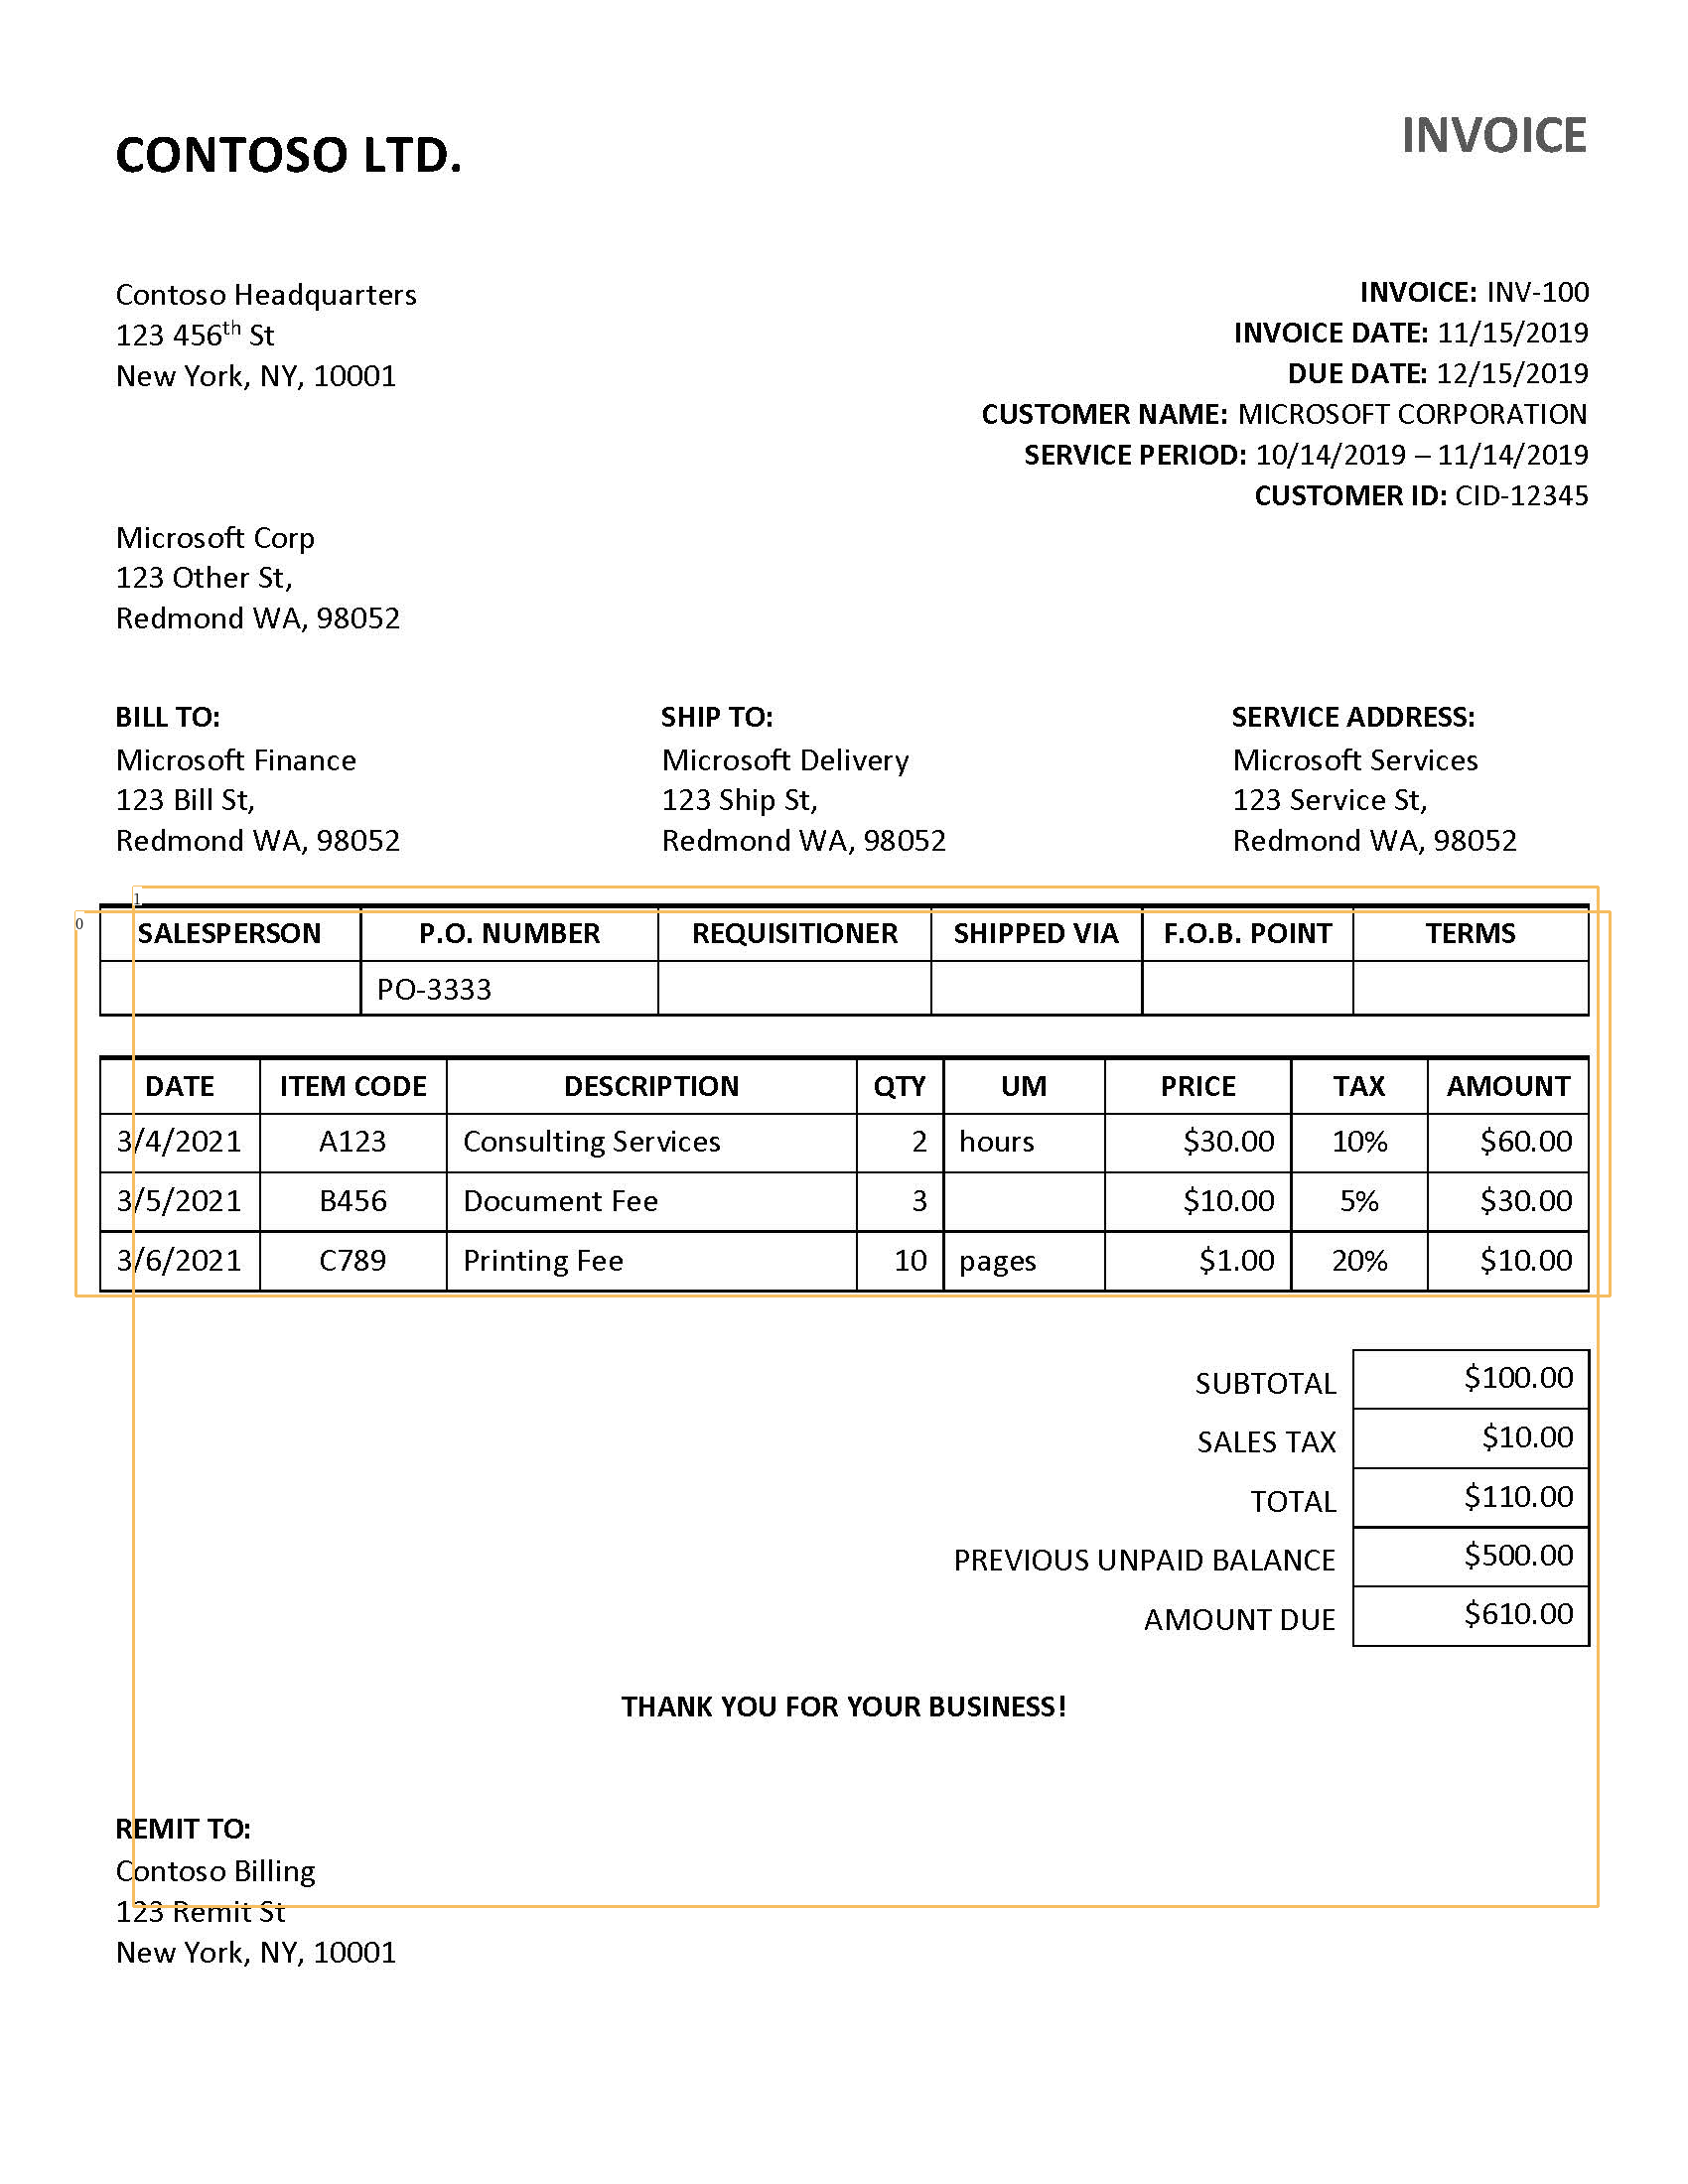

In [117]:
lp.draw_box(image2, text_blocks2,
            box_width=3, 
            show_element_id=True)

In [118]:
for block in text_blocks2:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image2))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [119]:
for txt in text_blocks2.get_texts():
    print(txt, end='\n---\n')

 

SALESPERSON

P.O. NUMBER

REQUISITIONER SHIPPED VIA

F.0.B. POINT

TERMS

 

PO-3333

 

 

 

 

 

 

 

DATE ITEM CODE DESCRIPTION QTY TAX AMOUNT
3/4/2021 A123 Consulting Services 2 | hours 10% $60.00
3/5/2021 B456 Document Fee 3 5% $30.00
3/6/2021 C789 Printing Fee 10 20% $10.00

 

 

 

 

 

 

 

---
SALESPERSON P.O. NUMBER REQUISITIONER SHIPPED VIA | F.O.B. POINT TERMS

 

PO-3333

 

   
   
  
  

 

 

DATE ITEM CODE DESCRIPTION TAX AMOUNT
/4/2021 A123 Consulting Services 10% $60.00
/5/2021 B456 Document Fee 5% $30.00

 

 

 

 

 

 

/6/2021 C789 Printing Fee 20% $10.00
SUBTOTAL $100.00

SALES TAX $10.00

TOTAL $110.00

PREVIOUS UNPAID BALANCE $500.00
AMOUNT DUE $610.00

 

 

THANK YOU FOR YOUR BUSINESS!

EMIT TO:
ontoso Billing

39 D2... 4 Ch

---


In [120]:
text_blocks2.get_texts()

[' \n\nSALESPERSON\n\nP.O. NUMBER\n\nREQUISITIONER SHIPPED VIA\n\nF.0.B. POINT\n\nTERMS\n\n \n\nPO-3333\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nDATE ITEM CODE DESCRIPTION QTY TAX AMOUNT\n3/4/2021 A123 Consulting Services 2 | hours 10% $60.00\n3/5/2021 B456 Document Fee 3 5% $30.00\n3/6/2021 C789 Printing Fee 10 20% $10.00\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\x0c',
 'SALESPERSON P.O. NUMBER REQUISITIONER SHIPPED VIA | F.O.B. POINT TERMS\n\n \n\nPO-3333\n\n \n\n   \n   \n  \n  \n\n \n\n \n\nDATE ITEM CODE DESCRIPTION TAX AMOUNT\n/4/2021 A123 Consulting Services 10% $60.00\n/5/2021 B456 Document Fee 5% $30.00\n\n \n\n \n\n \n\n \n\n \n\n \n\n/6/2021 C789 Printing Fee 20% $10.00\nSUBTOTAL $100.00\n\nSALES TAX $10.00\n\nTOTAL $110.00\n\nPREVIOUS UNPAID BALANCE $500.00\nAMOUNT DUE $610.00\n\n \n\n \n\nTHANK YOU FOR YOUR BUSINESS!\n\nEMIT TO:\nontoso Billing\n\n39 D2... 4 Ch\n\x0c']

In [121]:
for block in text_blocks2:
  print(block)

TextBlock(block=Rectangle(x_1=76.35953521728516, y_1=918.3372192382812, x_2=1621.434326171875, y_2=1305.1419677734375), text= 

SALESPERSON

P.O. NUMBER

REQUISITIONER SHIPPED VIA

F.0.B. POINT

TERMS

 

PO-3333

 

 

 

 

 

 

 

DATE ITEM CODE DESCRIPTION QTY TAX AMOUNT
3/4/2021 A123 Consulting Services 2 | hours 10% $60.00
3/5/2021 B456 Document Fee 3 5% $30.00
3/6/2021 C789 Printing Fee 10 20% $10.00

 

 

 

 

 

 

 
, id=0, type=Table, parent=None, next=None, score=0.7971948385238647)
TextBlock(block=Rectangle(x_1=134.96868896484375, y_1=893.4752197265625, x_2=1609.5634765625, y_2=1920.9112548828125), text=SALESPERSON P.O. NUMBER REQUISITIONER SHIPPED VIA | F.O.B. POINT TERMS

 

PO-3333

 

   
   
  
  

 

 

DATE ITEM CODE DESCRIPTION TAX AMOUNT
/4/2021 A123 Consulting Services 10% $60.00
/5/2021 B456 Document Fee 5% $30.00

 

 

 

 

 

 

/6/2021 C789 Printing Fee 20% $10.00
SUBTOTAL $100.00

SALES TAX $10.00

TOTAL $110.00

PREVIOUS UNPAID BALANCE $500.00
AMOUNT 

In [122]:
sentence2=["".join(txt) for txt in text_blocks2.get_texts()]

In [123]:
sentence2

[' \n\nSALESPERSON\n\nP.O. NUMBER\n\nREQUISITIONER SHIPPED VIA\n\nF.0.B. POINT\n\nTERMS\n\n \n\nPO-3333\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nDATE ITEM CODE DESCRIPTION QTY TAX AMOUNT\n3/4/2021 A123 Consulting Services 2 | hours 10% $60.00\n3/5/2021 B456 Document Fee 3 5% $30.00\n3/6/2021 C789 Printing Fee 10 20% $10.00\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\x0c',
 'SALESPERSON P.O. NUMBER REQUISITIONER SHIPPED VIA | F.O.B. POINT TERMS\n\n \n\nPO-3333\n\n \n\n   \n   \n  \n  \n\n \n\n \n\nDATE ITEM CODE DESCRIPTION TAX AMOUNT\n/4/2021 A123 Consulting Services 10% $60.00\n/5/2021 B456 Document Fee 5% $30.00\n\n \n\n \n\n \n\n \n\n \n\n \n\n/6/2021 C789 Printing Fee 20% $10.00\nSUBTOTAL $100.00\n\nSALES TAX $10.00\n\nTOTAL $110.00\n\nPREVIOUS UNPAID BALANCE $500.00\nAMOUNT DUE $610.00\n\n \n\n \n\nTHANK YOU FOR YOUR BUSINESS!\n\nEMIT TO:\nontoso Billing\n\n39 D2... 4 Ch\n\x0c']

In [124]:
".".join(sentence2)

' \n\nSALESPERSON\n\nP.O. NUMBER\n\nREQUISITIONER SHIPPED VIA\n\nF.0.B. POINT\n\nTERMS\n\n \n\nPO-3333\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nDATE ITEM CODE DESCRIPTION QTY TAX AMOUNT\n3/4/2021 A123 Consulting Services 2 | hours 10% $60.00\n3/5/2021 B456 Document Fee 3 5% $30.00\n3/6/2021 C789 Printing Fee 10 20% $10.00\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\x0c.SALESPERSON P.O. NUMBER REQUISITIONER SHIPPED VIA | F.O.B. POINT TERMS\n\n \n\nPO-3333\n\n \n\n   \n   \n  \n  \n\n \n\n \n\nDATE ITEM CODE DESCRIPTION TAX AMOUNT\n/4/2021 A123 Consulting Services 10% $60.00\n/5/2021 B456 Document Fee 5% $30.00\n\n \n\n \n\n \n\n \n\n \n\n \n\n/6/2021 C789 Printing Fee 20% $10.00\nSUBTOTAL $100.00\n\nSALES TAX $10.00\n\nTOTAL $110.00\n\nPREVIOUS UNPAID BALANCE $500.00\nAMOUNT DUE $610.00\n\n \n\n \n\nTHANK YOU FOR YOUR BUSINESS!\n\nEMIT TO:\nontoso Billing\n\n39 D2... 4 Ch\n\x0c'

In [125]:
doc = nlp(".".join(sentence2))
for ent in doc.ents:
  print(ent.text,ent.label_)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


10% PERCENT
60.00 MONEY
3 5% PERCENT
30.00 MONEY
10 20% PERCENT
10.00 MONEY
10% PERCENT
60.00 MONEY
5% PERCENT
30.00 MONEY
20% PERCENT
10.00 MONEY
100.00 MONEY
10.00 MONEY
110.00 MONEY
500.00 MONEY
610.00 MONEY
